In [1]:
import numpy as np

import pandas as pd

#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('Cell_Level_KPI_5 layer site_ML-One sector.csv')
df.head()

,Radio Site_Sector_Date_Hour,Hour,Date,Date_Time,Sector_PDSCH_PRB_DL_Util,Sector_PUSCH_PRB_UL_Util,Sector_VoLTE_Traffic_Erl,Sector_Avg_RRC_connected_users,Capacity_On_Off
0,90851_3_44388_ 00:00,00:00,11-Jul,11/7/2021 0:00,18.12,3.45,0.32,22.0,On
1,90851_3_44388_ 00:00,00:00,11-Jul,11/7/2021 0:00,18.12,3.45,0.32,22.0,On
2,90851_3_44388_ 00:00,00:00,11-Jul,11/7/2021 0:00,18.12,3.45,0.32,22.0,Off
3,90851_3_44388_ 00:00,00:00,11-Jul,11/7/2021 0:00,18.12,3.45,0.32,22.0,Off
4,90851_3_44388_ 00:00,00:00,11-Jul,11/7/2021 0:00,18.12,3.45,0.32,22.0,Off


In [3]:
#df.info()

In [4]:
df['Date_Time']= pd.to_datetime(df['Date_Time'])

In [5]:
#df.info()

In [6]:
df.Capacity_On_Off[df.Capacity_On_Off == 'On'] = 1
df.Capacity_On_Off[df.Capacity_On_Off == 'Off'] = 0

<ipython-input-6-b8846d583b5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Capacity_On_Off[df.Capacity_On_Off == 'On'] = 1
<ipython-input-6-b8846d583b5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Capacity_On_Off[df.Capacity_On_Off == 'Off'] = 0


In [7]:
df = df.rename({
          'Capacity_On_Off':'On'
        }, axis='columns')

In [8]:
df ['On'] =df['On'].astype('int')

In [9]:
df.head()

,Radio Site_Sector_Date_Hour,Hour,Date,Date_Time,Sector_PDSCH_PRB_DL_Util,Sector_PUSCH_PRB_UL_Util,Sector_VoLTE_Traffic_Erl,Sector_Avg_RRC_connected_users,On
0,90851_3_44388_ 00:00,00:00,11-Jul,2021-11-07,18.12,3.45,0.32,22.0,1
1,90851_3_44388_ 00:00,00:00,11-Jul,2021-11-07,18.12,3.45,0.32,22.0,1
2,90851_3_44388_ 00:00,00:00,11-Jul,2021-11-07,18.12,3.45,0.32,22.0,0
3,90851_3_44388_ 00:00,00:00,11-Jul,2021-11-07,18.12,3.45,0.32,22.0,0
4,90851_3_44388_ 00:00,00:00,11-Jul,2021-11-07,18.12,3.45,0.32,22.0,0


In [10]:
#df.tail()

In [11]:
df1=df.reset_index()['On']

In [12]:
df1.head()

0    1
1    1
2    0
3    0
4    0
Name: On, dtype: int32

In [13]:
#df1 = np.array(df1)

In [14]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)


In [16]:
training_size

595

In [17]:
test_size=len(df1)-training_size
test_size

321

In [18]:
train_data, test_data =df1[0:training_size,:],df1[training_size:len(df1),:1]

In [19]:
train_data.shape

(595, 1)

In [20]:
test_data.shape

(321, 1)

In [21]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-0):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24
# Here time_step is the no of hours to look back based on which prediction for (time_step+1) is to be predicted
X_train, y_train = create_dataset(train_data, time_step)

In [23]:
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
print(X_train.shape), print(y_train.shape)

(571, 24)
(571,)


(None, None)

In [25]:
print(X_test.shape), print(ytest.shape)

(297, 24)
(297,)


(None, None)

In [26]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
# model.add(LSTM()) # not needed check if this is line is to be removed?

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 15s 400ms/step - loss: 0.3519 - val_loss: 0.2660
Epoch 2/100
9/9 [==============================] - 1s 88ms/step - loss: 0.2566 - val_loss: 0.2554
Epoch 3/100
9/9 [==============================] - 1s 82ms/step - loss: 0.2531 - val_loss: 0.2483
Epoch 4/100
9/9 [==============================] - 1s 85ms/step - loss: 0.2567 - val_loss: 0.2485
Epoch 5/100
9/9 [==============================] - 1s 87ms/step - loss: 0.2541 - val_loss: 0.2470
Epoch 6/100
9/9 [==============================] - 1s 84ms/step - loss: 0.2525 - val_loss: 0.2489
Epoch 7/100
9/9 [==============================] - 1s 87ms/step - loss: 0.2500 - val_loss: 0.2470
Epoch 8/100
9/9 [==============================] - 1s 76ms/step - loss: 0.2548 - val_loss: 0.2470
Epoch 9/100
9/9 [==============================] - 1s 88ms/step - loss: 0.2504 - val_loss: 0.2471
Epoch 10/100
9/9 [==============================] - 1s 83ms/step - loss: 0.2510 - val_loss: 0.2464
Epoch 11/100
9/9 

Epoch 84/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0669 - val_loss: 0.1114
Epoch 85/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0620 - val_loss: 0.1157
Epoch 86/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0639 - val_loss: 0.1130
Epoch 87/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0643 - val_loss: 0.1130
Epoch 88/100
9/9 [==============================] - 1s 84ms/step - loss: 0.0629 - val_loss: 0.1138
Epoch 89/100
9/9 [==============================] - 1s 85ms/step - loss: 0.0602 - val_loss: 0.1161
Epoch 90/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0613 - val_loss: 0.1169
Epoch 91/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0619 - val_loss: 0.1151
Epoch 92/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0613 - val_loss: 0.1134
Epoch 93/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0598 - val_loss: 0.1158
Epoch 94

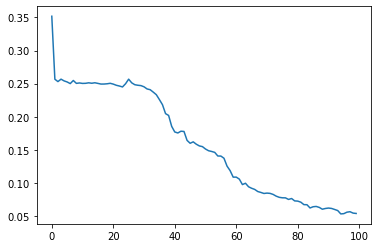

In [33]:
import matplotlib.pyplot as plt

loss_per_epoch= model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [34]:
import tensorflow as tf

In [35]:
tf.__version__

'2.6.0'

# Now we will predict for Train and Test data and find the accuracy of both predictions.

In [36]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [37]:
len(X_train)

571

In [38]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
train_predict = np.round(train_predict)

In [40]:
#train_predict = pd.DataFrame(train_predict, columns=['train_predict']).to_csv('train_predict.csv')

In [41]:
test_predict = np.round(test_predict)

In [42]:
len(train_predict)

571

In [43]:
len(test_predict)

297

In [44]:
#test_predict = pd.DataFrame(test_predict, columns=['test_predict']).to_csv('test_predict.csv')

In [45]:
#1.  Create an numpy array with 'time_step' number of values in it
#2. Append Train_predict to this array
#3. Append 'time_step' numebr of values to this.
#4. Finally, append Test_predict to this array

In [46]:
temp_arr1 = []
for k in range(0,(time_step)):
    temp_arr1 += [k+100]  # 100 added here just to keep the numbers differnt form 0 and 1- easier to filerout in excel later.

temp_arr2 = np.append(temp_arr1,train_predict)
len(temp_arr2)

595

In [47]:
temp_arr3 = []
for k in range(0,(time_step)):
    temp_arr3 += [k+100] # 100 added here just to keep the numbers differnt form 0 and 1- easier to filerout in excel later.

temp_arr4= np.append(temp_arr2,temp_arr3)
temp_arr5= np.append(temp_arr4,test_predict)
len(temp_arr5)

916

In [48]:
train_test_predict = pd.DataFrame(temp_arr5, columns=['temp_arr5']).to_csv('PREDICT.csv')

In [49]:
#zbc = np.isnan(train_predict)

In [50]:
#countNAN = np.where (zbc== 'True')

In [51]:
#countNAN

In [52]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.25109218519121235

In [53]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.37154695268180854

In [54]:
train_predict

array([[ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [-0.],
       [ 1.],
       [ 0.],
      

In [55]:
### Plotting train_predict and test_predict
# shift train predictions for plotting
from matplotlib import pyplot as plt
look_back=time_step   # this value should be same as time_step considerd in code above.
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (297,1) into shape (295,1)

In [56]:

len(test_data)

321

# Below code is for predicting values for a future date (beyond test data set). Of course we wont be able to validate how accurate that prediction is, since we dont have any future data.

In [57]:
len(test_data)

321

In [58]:
# If the 'last hour of last date' in our entire data set is say Hour- H24 of Day- D7. 
# If we have to predict H1 of D8 looking back H24 - 24 (24 hrs before), then this is calaculated as below.

new = (len(test_data)-time_step)

In [59]:
# 
x_input=test_data[new:].reshape(1,-1) 

## first agument in test_data should be the output of earlier executed command print(ytest.shape) and add 1 to it
# .==remove above comment??

x_input.shape

(1, 24)

In [60]:
# Below will give list of values for the period 'time_step'
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [61]:
# demonstrate prediction for next x no of time steps in the future
from numpy import array

lst_output=[]
n_steps=time_step # step size should be same as was chosen in the code earlier/above 
i=0
while(i<48):   # value of i to be given here as the no of time steps in the future that we want to predict for
                # This is basically how many hours after last hour of our data set do we want to predict considering look
                # back period of time_step (time_step is defined earlier)
    
    if(len(temp_input)>time_step): # value givne here should be same a time_steps used in earlier code above.
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.0644778]
25
1 day input [0.        0.        0.        1.        1.        0.        1.
 0.        1.        1.        0.        1.        0.        1.
 1.        0.        1.        0.        1.        1.        0.
 1.        0.        1.0644778]
1 day output [[1.0263095]]
2 day input [0.         0.         1.         1.         0.         1.
 0.         1.         1.         0.         1.         0.
 1.         1.         0.         1.         0.         1.
 1.         0.         1.         0.         1.0644778  1.02630949]
2 day output [[-0.04389888]]
3 day input [ 0.          1.          1.          0.          1.          0.
  1.          1.          0.          1.          0.          1.
  1.          0.          1.          0.          1.          1.
  0.          1.          0.          1.0644778   1.02630949 -0.04389888]
3 day output [[0.67407244]]
4 day input [ 1.          1.          0.          1.          0.          1.
  1.          0.          1.          0.          

26 day output [[0.1257044]]
27 day input [ 0.67407244  0.13342023  1.10539091  0.91570121 -0.05471264  0.6574263
  0.21076843  1.13383234  0.78843099 -0.0285854   0.66114062  0.29678771
  1.15539348  0.62662113  0.01503357  0.65240097  0.41000241  1.16297674
  0.40320367  0.08986052  0.6182158   0.56592786  1.13815784  0.12570439]
27 day output [[0.28241184]]
28 day input [ 0.13342023  1.10539091  0.91570121 -0.05471264  0.6574263   0.21076843
  1.13383234  0.78843099 -0.0285854   0.66114062  0.29678771  1.15539348
  0.62662113  0.01503357  0.65240097  0.41000241  1.16297674  0.40320367
  0.08986052  0.6182158   0.56592786  1.13815784  0.12570439  0.28241184]
28 day output [[0.40087038]]
29 day input [ 1.10539091  0.91570121 -0.05471264  0.6574263   0.21076843  1.13383234
  0.78843099 -0.0285854   0.66114062  0.29678771  1.15539348  0.62662113
  0.01503357  0.65240097  0.41000241  1.16297674  0.40320367  0.08986052
  0.6182158   0.56592786  1.13815784  0.12570439  0.28241184  0.4008703

Convert predicted value to categorical output, round it.

In [62]:
lst_output = np.round(lst_output)

In [63]:
# below second argument should be n_steps from above and add 1 to it
day_new=np.arange(1,time_step+1)
# below first agument should be n_steps from above and add 1 to it.
# below second agument should be-> n_steps+ number future time steps that we wnat to predict in the future. 
# This value of future time steps is given in above code while(i<100)
day_pred=np.arange(time_step+1,time_step+i+1)

# above i+1 is added, since in the earlier code, i value is true only till it is '<48', and to get 48 i+1 is done. 

In [64]:
#day_pred

In [65]:
print("Predicting for future", i, "hours, looking", time_step, "hours back")

Predicting for future 48 hours, looking 24 hours back


In [66]:
import matplotlib.pyplot as plt

In [67]:
var1 = len(df1)-time_step

In [68]:
#var1

In [69]:
#len(df1[var1:])

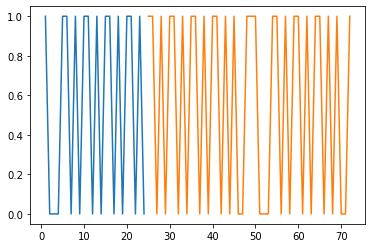

In [70]:
# Value belos should be len(df1) minus value of future time step as considered above
plt.plot(day_new,scaler.inverse_transform(df1[var1:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

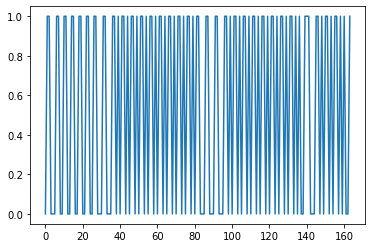

In [71]:
# This shows complete plot of train, test and future date prediction plot- all in one plot.
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[800:]) # dont know the meaning of the value in this code but surely has no relation with above code at all.